### Index
<ol>1 <strong>Introduction</strong><br>
    2 <b>Import Data</b><br>
    3 <b>Data Cleaning</b><br>
    <ol><i>Aggragation of Tables<br>
        Check for Missing Values<br>
        Feature Validation<br>
        Outliers Removal</i></ol>
    4 <b>EDA</b><br>
    5 <b>Feature Engineering</b>
    <ol><i>Feature Selection<br>
        Target Clipping<br>
        Feature Extraction<br>
        Construction of Monthly Sales Dataframe<br>
        Previous Value Benchmark<br>
        Log Transformation<br></i></ol>
    </ol>

### 1 Introduction

In this competition, work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. Predict total sales for every product and store in the next month.

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

#### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month`<br>
`0,0.5`<br>
`1,0.5`<br>
`2,0.5`<br>
`3,0.5`<br>
`etc.`<br>

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

#### Data Description

The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

##### File descriptions

* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
* **sample_submission.csv** - a sample submission file in the correct format.
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv**- supplemental information about the shops.

##### Data fields

* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category

The author recommends producing Previous Value Benchmark in which for each shop/item pair the prediction is just monthly sales from the previous month, i.e October 2015. This will require generating lagged values. It is recommended to fill NaNs with 0 and to clip the target values into [0:20] range. Such technique is a necessary basis for more complex models.

### 2 Import Data

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import skew

import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../sales_train.csv", 
                    dtype={'date': 'str', 'date_block_num': 'int8', 'shop_id': 'int8', 'item_id': 'int16', 'item_price': 'float32', 'item_cnt_day': 'int16'})
test = pd.read_csv("../test.csv", dtype={'ID': 'int32', 'shop_id': 'int8', 'item_id': 'int16'})

items = pd.read_csv("../items.csv", dtype={'item_name': 'str', 'item_id': 'int16', 'item_category_id': 'int8'})
item_cat = pd.read_csv("../item_categories.csv", dtype={'item_category_name': 'str', 'item_category_id': 'int8'})
shops = pd.read_csv("../shops.csv", dtype={'shop_name': 'str', 'shop_id': 'int8'})

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int8   
 2   shop_id         int8   
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    int16  
dtypes: float32(1), int16(2), int8(2), object(1)
memory usage: 39.2+ MB


Table *train* contains daily sales records of date, shop id's, item id's, item prices, item count per day.

In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Table *test* contains ID for every (shop,item) tuple, shop id's, item id's. To be used for prediction as the final step of this project.

In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Table *items* contains item names and item category id's for each item id.

In [7]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Table *item_cat* contains item category names for each item category id.

In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Table *shops* contains shop names for each shop id.

### 3 Data Cleaning

#### Aggreagation of Tables

Dataset provided and contained features are as following (*test* set to be used for final prediction excluded): 
* *train* containing **date**, **date_block_num**, **shop_id**, **item_id**, **item_price**, **item_cnt_day**
* *items* containing **item_name**, **item_id**, **item_category_id**
* *item_cat* containing **item_category_name**, **item_category_id**
* *shops* containing **shop_name**, **shop_id**

It is best to aggregate all the information from different datasets into one large train set, as doing so would provide a better summary of product details.

Append the following rows from tables *items*, *item_cat*, *shops* to table *train* for a combined train set.
* **item_name** and **item_category_id** from table *items* mapped by item_id from table *train*
* **item_category_name** from table *item_cat* mapped by item_category_id originally from table *items*
* **shop_name** from table *shops* mapped by shop_id from table *train*

In [9]:
train['item_name'] = train['item_id'].map(items.set_index('item_id')['item_name'])
train['item_category_id'] = train['item_id'].map(items.set_index('item_id')['item_category_id'])
train['item_category_name'] = train['item_category_id'].map(item_cat.set_index('item_category_id')['item_category_name'])
train['shop_name'] = train['shop_id'].map(shops.set_index('shop_id')['shop_name'])

# reorder columns
train = train[['date', 'date_block_num', 'item_id', 'item_name', 'item_category_id', 'item_category_name', 'shop_id', 'shop_name', 'item_price', 'item_cnt_day']]

train.head()

,date,date_block_num,item_id,item_name,item_category_id,item_category_name,shop_id,shop_name,item_price,item_cnt_day
0,02.01.2013,0,22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",999.00,1
1,03.01.2013,0,2552,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,25,"Москва ТРК ""Атриум""",899.00,1
2,05.01.2013,0,2552,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,25,"Москва ТРК ""Атриум""",899.00,-1
3,06.01.2013,0,2554,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,25,"Москва ТРК ""Атриум""",1709.05,1
4,15.01.2013,0,2555,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,25,"Москва ТРК ""Атриум""",1099.00,1


#### Check for Missing Values

In [10]:
print("Any null values in the train and the test set?")
if train.isnull().values.any() == False and test.isnull().values.any() == False:
    print("No Null Values")

Any null values in the train and the test set?
No Null Values


#### Data Validation

For validity, it is safe to ensure the following conditions:
* Columns **date_block_num**, **item_id**, **item_category_id**, **shop_id** contain no negative integers.
* All **item_price** values are greater than or equal to 0. If less than 0, replace with 0.

It is unnecessary to check **item_cnt_day** at the current phase, as **item_cnt_day** will be clipped to [0:20] during Feature Engineering.

In [11]:
train[['date_block_num', 'item_id', 'item_category_id', 'shop_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 4 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int8 
 1   item_id           int16
 2   item_category_id  int8 
 3   shop_id           int8 
dtypes: int16(1), int8(3)
memory usage: 14.0 MB


In [12]:
print("Are all values in columns date_block_num, item_id, item_category_id, shop_id 0 or positive integers?")
if (train[train.date_block_num<0].values.any() == False and train[train.item_id<0].values.any() == False and 
    train[train.item_category_id<0].values.any() == False and train[train.shop_id<0].values.any() == False):
    print("Yes")
else:
    print("There exists invalid ID values.")

Are all values in columns date_block_num, item_id, item_category_id, shop_id 0 or positive integers?
Yes


In [13]:
print("Are all item price values greater than 0?")
if train[train.item_price<0].values.any() == False:
    print("Yes")
else:
    print("There exists " + str(len(train.loc[train.item_price<0])) + " invalid item price value(s).")
    
train.loc[train.item_price<0]

Are all item price values greater than 0?
There exists 1 invalid item price value(s).


,date,date_block_num,item_id,item_name,item_category_id,item_category_name,shop_id,shop_name,item_price,item_cnt_day
484683,15.05.2013,4,2973,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,32,"Москва ТЦ ""Серебряный Дом""",-1.00,1


In [14]:
# replace the invalid item_price value with 0 and check again
train['item_price'] = np.where(train['item_price'] < 0, 0, train['item_price'])

print("Are all item price values greater than 0?")
if train[train.item_price<0].values.any() == False:
    print("Yes")
else:
    print("There exists " + str(len(train.loc[train.item_price<0])) + " invalid item price value(s).")

Are all item price values greater than 0?
Yes


#### Outliers Removal

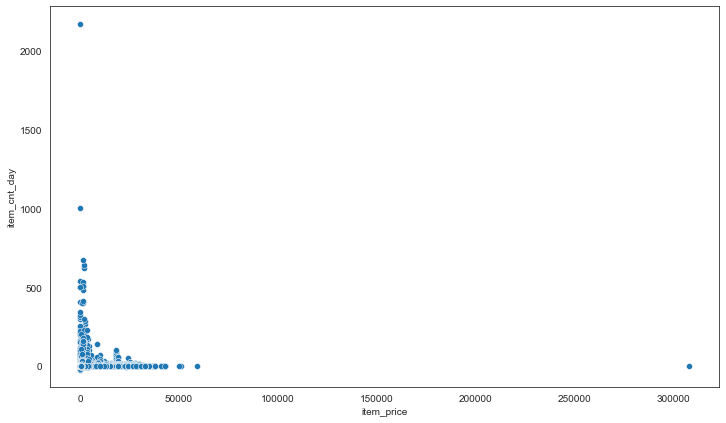

In [15]:
sns.set_style(style="white")

plt.figure(figsize=(12, 7))
sns.scatterplot(x='item_price', y='item_cnt_day', data=train)

plt.savefig('outliers.png')

In [16]:
train.loc[train['item_price'] > 100000]

,date,date_block_num,item_id,item_name,item_category_id,item_category_name,shop_id,shop_name,item_price,item_cnt_day
1163158,13.12.2013,11,6066,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,12,Интернет-магазин ЧС,307980.00,1


There exists one outlier with an item price of 307980 that would be better to remove.

In [17]:
train = train[train.item_price < 100000]

### 4 EDA/Data Exploration - add description

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935848 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   item_id             int16  
 3   item_name           object 
 4   item_category_id    int8   
 5   item_category_name  object 
 6   shop_id             int8   
 7   shop_name           object 
 8   item_price          float32
 9   item_cnt_day        int16  
dtypes: float32(1), int16(2), int8(3), object(4)
memory usage: 98.0+ MB


In [19]:
print("Time period covered: " + "From " + train.date.str[3:].unique()[0] + " to " + train.date.str[3:].unique()[33])
print("Number of months covered: " + str(len(train.date_block_num.unique())))

Time period covered: From 01.2013 to 10.2015
Number of months covered: 34


In [20]:
train[['item_price','item_cnt_day']].describe()

,item_price,item_cnt_day
count,2935848.00,2935848.00
mean,890.75,1.24
std,1720.49,2.62
min,0.00,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,59200.00,2169.00


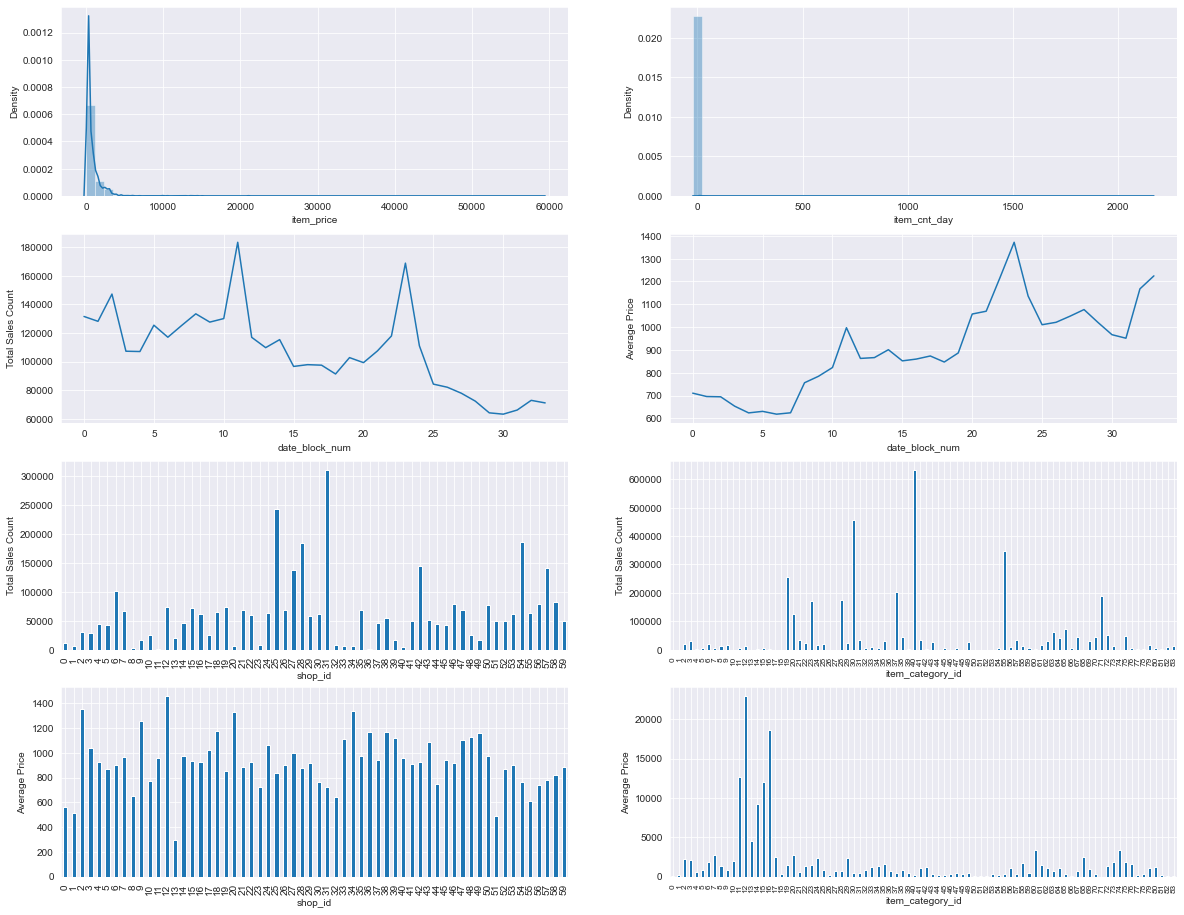

In [21]:
sns.set_style(style="darkgrid")

f, ax = plt.subplots(4, 2, figsize=(20,16))

sns.distplot(x=train.item_price, axlabel="item_price", ax=ax[0,0]) # item_price distribution

sns.distplot(x=train.item_cnt_day, axlabel="item_cnt_day", ax=ax[0,1]) # item_cnt_day distribution

train.groupby('date_block_num').item_cnt_day.sum().plot(ax=ax[1,0]) # total sales count per month
ax[1,0].set_ylabel('Total Sales Count')

train.groupby('date_block_num').item_price.mean().plot(ax=ax[1,1]) # average price per month
ax[1,1].set_ylabel('Average Price')

train.groupby('shop_id').item_cnt_day.sum().plot(kind='bar', ax=ax[2,0]) # total sales count per shop
ax[2,0].set_ylabel('Total Sales Count')

train.groupby('item_category_id').item_cnt_day.sum().plot(kind='bar', ax=ax[2,1]) # total sales count per item category
ax[2,1].tick_params(axis='x', labelsize=8.24)
ax[2,1].set_ylabel('Total Sales Count')

train.groupby('shop_id').item_price.mean().plot(kind='bar', ax=ax[3,0]) # average price per shop
ax[3,0].set_ylabel('Average Price')

train.groupby('item_category_id').item_price.mean().plot(kind='bar', ax=ax[3,1]) # average price per item category
ax[3,1].tick_params(axis='x', labelsize=8.24)
ax[3,1].set_ylabel('Average Price')

plt.savefig('exploration1.png')

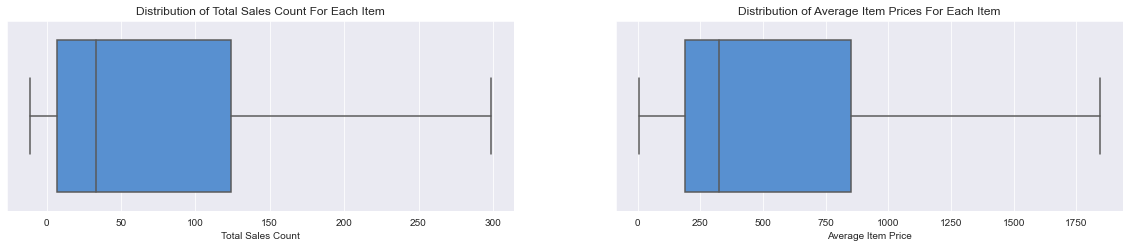

In [22]:
f, ax = plt.subplots(1, 2, figsize=(20,3.5))

sns.boxplot(train.groupby(['item_id'])['item_cnt_day'].sum(), showfliers=False, color='#448ee4', ax=ax[0]) # distribution of total sales count for each item
ax[0].set_title('Distribution of Total Sales Count For Each Item')
ax[0].set_xlabel('Total Sales Count')

sns.boxplot(train.groupby(['item_id'])['item_price'].mean(), showfliers=False, color='#448ee4', ax=ax[1]) # distrubution of average item prices for each item
ax[1].set_title('Distribution of Average Item Prices For Each Item')
ax[1].set_xlabel('Average Item Price')

plt.savefig('exploration2.png')

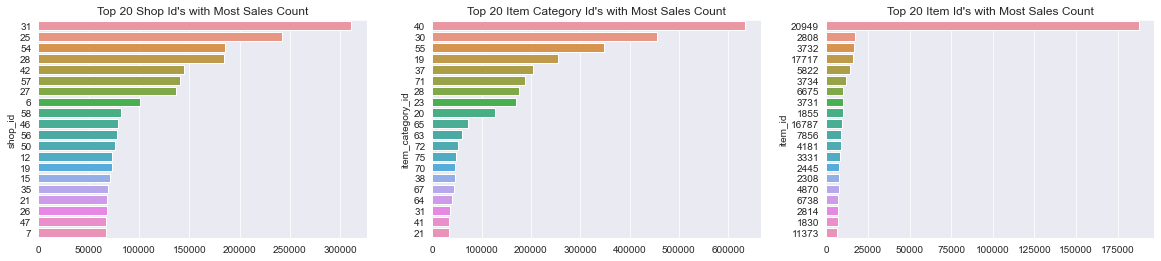

In [23]:
f, ax = plt.subplots(1, 3, figsize=(20,4))

sns.barplot(y=train.groupby(['shop_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, 
            x=train.groupby(['shop_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].tolist(), 
            order=train.groupby(['shop_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, orient='h', ax=ax[0])
ax[0].set_title('Top 20 Shop Id\'s with Most Sales Count')

sns.barplot(y=train.groupby(['item_category_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, 
            x=train.groupby(['item_category_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].tolist(), 
            order=train.groupby(['item_category_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, orient='h', ax=ax[1])
ax[1].set_title('Top 20 Item Category Id\'s with Most Sales Count')

sns.barplot(y=train.groupby(['item_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, 
            x=train.groupby(['item_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].tolist(), 
            order=train.groupby(['item_id'])['item_cnt_day'].sum().sort_values(ascending=False)[:20].index, orient='h', ax=ax[2])
ax[2].set_title('Top 20 Item Id\'s with Most Sales Count')

plt.savefig('exploration3.png')

In [24]:
print("10 Most Frequent Item Prices:\n" + str(train.item_price.value_counts().head(10)))
print('_'*150 + '\n')
print("10 Highest Item Prices: " + str(sorted(train.item_price.unique(), reverse=True)[:10]))
print('_'*150 + '\n')
print("10 Lowest Item Prices: " + str(sorted(train.item_price.unique())[:10]))
print('_'*150 + '\n')
print("10 Most Frequent Daily Sales Count:\n" + str(train.item_cnt_day.value_counts().head(10)))
print('_'*150 + '\n')
print("10 Highest Daily Sales Count: " + str(sorted(train.item_cnt_day.unique(), reverse=True)[:10]))
print('_'*150 + '\n')
print("10 Lowest Daily Sales Count: " + str(sorted(train.item_cnt_day.unique())[9:20]) + '\n')

10 Most Frequent Item Prices:
299.00    291352
399.00    242603
149.00    218432
199.00    184044
349.00    101461
599.00     95673
999.00     82784
799.00     77882
249.00     77685
699.00     76493
Name: item_price, dtype: int64
______________________________________________________________________________________________________________________________________________________

10 Highest Item Prices: [59200.0, 50999.0, 49782.0, 42990.0, 42000.0, 41990.0, 40991.0, 40900.0, 37991.0, 36990.0]
______________________________________________________________________________________________________________________________________________________

10 Lowest Item Prices: [0.0, 0.07, 0.0875, 0.09, 0.1, 0.2, 0.5, 0.9087137, 0.99, 1.0]
______________________________________________________________________________________________________________________________________________________

10 Most Frequent Daily Sales Count:
 1    2629371
 2     194201
 3      47350
 4      19685
 5      10474
-1    

### 5 Feature Engineering

#### Feature Selection

Names of items, item categories, shops are not needed for the algorithms. Select only **date**, **date_block_num**, **item_id**, **item_category_id**, **shop_id**, **item_price**, **item_cnt_day** features for the training set.<br>

In [25]:
# drop unnecessary columns and reorder
train.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)
train = train[['date', 'date_block_num', 'item_id', 'item_category_id', 'shop_id', 'item_price', 'item_cnt_day']]

Since the datasets are of products, the values are discrete and are not related to their neighbor values. So dropping unnecessary values won't affect the algorithm.<br>
Drop all values in the train set that do not appear in the test set. Use only the values that appear in the test set.

In [26]:
train = train[train.shop_id.isin(test['shop_id'].unique())]
train = train[train.item_id.isin(test['item_id'].unique())]

#### Clip Target into [0:20] Range

In [27]:
train.item_cnt_day = train.item_cnt_day.clip(0,20)

#### Feature Extraction

In [28]:
# group by month in this case column date_block_num and aggregate features
train = train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train = train.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

# numeric column optimization
train[['date_block_num','shop_id','item_category_id','item_id','item_cnt','transactions']] = train[['date_block_num','shop_id','item_category_id','item_id',
                                                                                                    'item_cnt','transactions']].apply(pd.to_numeric,downcast='integer')
train[['item_price','mean_item_price','mean_item_cnt']] = train[['item_price','mean_item_price','mean_item_cnt']].apply(pd.to_numeric,downcast='float')

print(train.info())
train.head() # for every shop-item pair in each month, statistics calculated for item prices and item counts per day

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600159 entries, 0 to 600158
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_block_num    600159 non-null  int8   
 1   shop_id           600159 non-null  int8   
 2   item_category_id  600159 non-null  int8   
 3   item_id           600159 non-null  int16  
 4   item_price        600159 non-null  float32
 5   mean_item_price   600159 non-null  float32
 6   item_cnt          600159 non-null  int16  
 7   mean_item_cnt     600159 non-null  float32
 8   transactions      600159 non-null  int8   
dtypes: float32(3), int16(2), int8(4)
memory usage: 16.0 MB
None


,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,1,0.50,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


#### Construction of Monthly Sales DataFrame

In [29]:
# Build a complete monthly sales dataframe with all the possible combinations of ['date_block_num','shop_id','item_id'] from the test set,
# plus date_block_num 34 which is the target month to be predicted.

months = train['date_block_num'].unique().tolist()
months.append(34)

new = []
for i in months: 
    for shop in test['shop_id'].unique():
        for item in test['item_id'].unique():
            new.append([i, shop, item])
            
new = pd.DataFrame(new, dtype='int16')

old = train[['date_block_num', 'shop_id', 'item_id']].values.tolist()


new = new.append(old, ignore_index=True)
new.columns = ['date_block_num', 'shop_id', 'item_id']

new = new.apply(pd.to_numeric, downcast='integer')
new.drop_duplicates(keep=False, inplace=True)


train = train.append(new)
train['item_category_id'] = train['item_id'].map(items.set_index('item_id')['item_category_id'])
train.fillna(0, inplace=True) # fill in missing values with 0

train.item_category_id = train.item_category_id.astype('int8')
train.item_cnt = train.item_cnt.astype('int8')
train.transactions = train.transactions.astype('int8')

train.sort_values(by=['date_block_num','shop_id','item_category_id','item_id'], ignore_index=True, inplace=True)

print(train.info())
train.head() # each row represents a unique combination of month, shop id, item id from the test set; missing values are filled in with 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497000 entries, 0 to 7496999
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_category_id  int8   
 3   item_id           int16  
 4   item_price        float32
 5   mean_item_price   float32
 6   item_cnt          int8   
 7   mean_item_cnt     float32
 8   transactions      int8   
dtypes: float32(3), int16(1), int8(5)
memory usage: 135.8 MB
None


,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,0,5441,0.00,0.00,0,0.00,0
1,0,2,2,5572,10730.00,1532.86,9,1.29,7
2,0,2,2,5621,0.00,0.00,0,0.00,0
3,0,2,2,5634,0.00,0.00,0,0.00,0
4,0,2,2,5637,0.00,0.00,0,0.00,0


#### Previous Value Benchmark

Previous Value Benchmark is produced by generating lagged values of the previous month's total item counts, *item_cnt*. The new feature *item_cnt_lagged* represents total item counts for each item id from the previous month. For the target month November 2015 whose *date_block_num value* is 34, its item count is from that of October 2015, *date_block_num* of 33.

In [30]:
train['item_cnt_lagged'] = train['item_cnt'].shift(train.groupby(['date_block_num']).size()[0]).fillna(0).astype('int8')

#### Log Transformation

In [31]:
# a skewness with an absolute value > 0.5 is considered at least moderately skewed
train_skewness = train[['item_price','mean_item_price','item_cnt','mean_item_cnt','transactions','item_cnt_lagged']].apply(lambda x: skew(x))
train_skewness = train_skewness[abs(train_skewness) > 0.5]
train_skewed_features = train_skewness.index
train[train_skewed_features] = np.log1p(train[train_skewed_features])

#### Now the new train sales dataframe has been created. Each row represents information for each item_id for each date_block_num value (month). New statistical features have been extracted and skewed features have been log transformed. The dataframe is sorted in the following order: date_block_num, shop_id, item_category_id, item_id.

In [32]:
train

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_lagged
0,0,2,0,5441,0.00,0.00,0.00,0.00,0.00,0.00
1,0,2,2,5572,9.28,7.34,2.30,0.83,2.08,0.00
2,0,2,2,5621,0.00,0.00,0.00,0.00,0.00,0.00
3,0,2,2,5634,0.00,0.00,0.00,0.00,0.00,0.00
4,0,2,2,5637,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
7496995,34,59,79,17717,0.00,0.00,0.00,0.00,0.00,2.64
7496996,34,59,83,22087,0.00,0.00,0.00,0.00,0.00,1.95
7496997,34,59,83,22088,0.00,0.00,0.00,0.00,0.00,1.10
7496998,34,59,83,22091,0.00,0.00,0.00,0.00,0.00,0.69


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497000 entries, 0 to 7496999
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_category_id  int8   
 3   item_id           int16  
 4   item_price        float32
 5   mean_item_price   float32
 6   item_cnt          float32
 7   mean_item_cnt     float32
 8   transactions      float32
 9   item_cnt_lagged   float32
dtypes: float32(6), int16(1), int8(3)
memory usage: 207.3 MB


In [34]:
train.describe()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_lagged
count,7497000.00,7497000.00,7497000.00,7497000.00,7497000.00,7497000.00,7496671.00,7497000.00,7497000.00,7496671.00
mean,17.00,31.64,46.31,11019.40,0.54,0.50,-inf,0.06,0.08,-inf
std,10.10,17.56,16.72,6252.63,1.86,1.73,nan,0.20,0.29,nan
min,0.00,2.00,0.00,30.00,0.00,0.00,-inf,0.00,0.00,-inf
25%,8.00,16.00,37.00,5381.50,0.00,0.00,0.00,0.00,0.00,0.00
50%,17.00,34.50,43.00,11203.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,26.00,47.00,58.00,16071.50,0.00,0.00,0.00,0.00,0.00,0.00
max,34.00,59.00,83.00,22167.00,13.15,10.67,4.85,3.04,3.47,4.85
